In [30]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import ray
from ray.rllib.agents import ppo

from mdps.whited import cMDPWhited
from utils.distributions import ConstantDistribution, ParticleDistribution, UniformDistribution

In [31]:
# some utils used later

def prepare_animation(bar_container_, context_history_):
    """Used for animated plotting sampling precedure"""
    def animate(frame_number, data=context_history_):
        # simulate new data coming in
        x = data[frame_number][:, 1]
        n, _ = np.histogram(x, HIST_BINS)
        plt.title(f'{frame_number} posterior mean: {round(x.mean(), 5)}')
        for count, rect in zip(n, bar_container_.patches):
            rect.set_height(count)
        return bar_container_.patches

    return animate


# collect expert rollout

def get_rollouts(solver_, config):
    """Generate rollouts from a given solver and MDP(c)"""
    env_ = cMDPWhited(config=config)
    done_ = False
    obs_ = env_.reset()
    # run until episode ends
    gt_obs_arr_ = None
    gt_act_arr_ = None
    gt_rew_arr_ = None
    while not done_:
        action_ = solver_.compute_single_action(obs_)
        obs_, rewawrd_, done_, _ = env_.step(action_)
        if gt_obs_arr_ is None:
            gt_obs_arr_ = obs_
            gt_act_arr_ = [action_]
            gt_rew_arr_ = [rewawrd_]
        else:
            gt_obs_arr_ = np.vstack((gt_obs_arr_, obs_))
            gt_act_arr_ += [action_]
            gt_rew_arr_ += [rewawrd_+gt_rew_arr_[-1]]

    gt_act_arr_ = np.array(gt_act_arr_)
    gt_rew_arr_ = np.array(gt_rew_arr_)
    return gt_obs_arr_, gt_act_arr_, gt_rew_arr_

def plot_rollouts(gt_obs_arr_, gt_act_arr_, gt_rew_arr_):
    """Plot generated rollouts"""
    fig_, ax_1 = plt.subplots()
    fig_.set_size_inches(10, 6, forward=True)

    x = np.arange(start=0, stop=gt_rew_arr_.shape[0])
    ax_2 = ax_1.twinx()
    ax_1.plot(x, gt_rew_arr_, 'r-')
    ax_2.plot(x, gt_act_arr_, 'b-', alpha=0.3)

    ax_1.set_xlabel('time step')
    ax_1.set_ylabel('Reward', color='r')
    ax_2.set_ylabel('Action', color='b')
    plt.title('sample rewards and actions')
    plt.show()

In [6]:
c = {"context_distribution":
        ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15])),
     "psi_fn": 
      lambda i, k: 0.01*i**2/(2*k),
    }

In [7]:
ray.shutdown()
ray.init()
expert = ppo.PPOTrainer(env=cMDPWhited, config={
    "env_config": c,
    "framework": "torch",  # config to pass to env class
})

rews = []
for eps in range(25):
    res = expert.train()
    if eps % 5 == 0:
        print(eps, res['episode_reward_mean'])
    rews += [res['episode_reward_mean']]

2022-02-17 00:00:27,549	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-17 00:00:27,549	INFO trainer.py:743 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=91744) 2022-02-17 00:00:29,400	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=84912) 2022-02-17 00:00:29,400	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
2022-02-17 00:00:29,733	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-02-17 00:00:39,010	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 316505919075.0x the scale of `vf_clip_param`

0 -3165059190746.982


2022-02-17 00:00:48,578	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 183653444607.0x the scale of `vf_clip_param`. This means that it will take more than 183653444607.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-17 00:00:58,455	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 84446494213.0x the scale of `vf_clip_param`. This means that it will take more than 84446494213.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-17 00:01:08,012	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 11085969713.0x the scale of `vf_clip_param`. This means that it will take more than 11085969713.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-17 00:01:17,451	WARNING ppo.py:245 -- The magnitude of your 

5 -915455539.0608957


2022-02-17 00:01:36,233	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 28041790.0x the scale of `vf_clip_param`. This means that it will take more than 28041790.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-17 00:01:45,558	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 7137721.0x the scale of `vf_clip_param`. This means that it will take more than 7137721.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-17 00:01:54,897	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 1006280.0x the scale of `vf_clip_param`. This means that it will take more than 1006280.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-17 00:02:04,278	WARNING ppo.py:245 -- The magnitude of your environment rewards are 

10 -48755.519040442014


2022-02-17 00:02:23,087	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 898.0x the scale of `vf_clip_param`. This means that it will take more than 898.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.


15 544.6282745944246
20 680.8119668379107


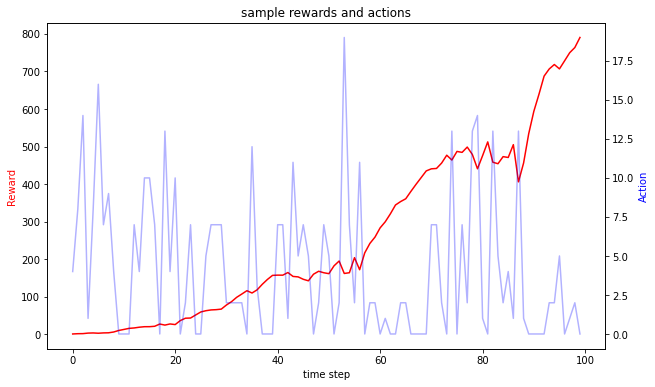

In [49]:
c_sim = {"context_distribution":
            ConstantDistribution(dim=5, constant_vector=np.array([0.98, 0.15, 0.7, 0.7, 0.15])),
         "psi_fn": 
            lambda i, k: 0.01*i**2/(2*k),
        }
gt_obs_arr, gt_act_arr, gt_rew_arr = get_rollouts(expert, config=c_sim)
plot_rollouts(gt_obs_arr, gt_act_arr, gt_rew_arr)

In [48]:
def filter_context(solver_,
                   context_distribution_,
                   gt_obs_arr_,
                   T_,
                   N_
                   ):
    state_arr_ = np.ones((N_,2))
    action_arr_ = np.zeros((N_,))
    context_history_ = []
    for t_ in range(T_):
        # we only use the first 5 steps of the cartpole steps to reduce effect of different episode lengths
        qs_ = np.zeros((N_,))
        for n_ in range(N_):
            context_ = context_distribution_.particles[n_]
            c_local_ = {"context_distribution":
                           ConstantDistribution(dim=5,
                                                constant_vector=context_),
                        "psi_fn": 
                            lambda i, k: 0.01*i**2/(2*k)}
            env_ = cMDPWhited(config=c_local_)
            obs_ = env_.reset()
            if t_ > 0:
                env_.mdp.state = state_arr_[n_]
                obs_ = np.concatenate((np.array(env_.mdp.state), context_), axis=0).flatten()
            action_ = solver_.compute_single_action(obs_)
            obs_, reward_, _, _ = env_.step(action_)
            # estimate likelihood if r >= 1
            action_arr_[n_] = action_
            if t_ >= 1:
                q = env_.likelihood(gt_obs_arr_[t_], action_arr_[n_], obs_, reward_)
                qs_[n_] = q
            state_arr_[n_] = np.copy(env_.mdp.state)
        if t_ >= 1:
            # truncated importance sampling; [https://arxiv.org/pdf/1905.09800.pdf]
            # qs_ = np.clip(qs_, 1E-99, 1.0)
            if qs_.sum() == 0:
                continue
            qs_ = qs_ / qs_.sum()
            resample_index_ = context_distribution_.resample_particles_from_probability(p=qs_)
            p_temp_ = context_distribution_.particles
            p_noise_ = np.random.normal(loc=0, scale=p_temp_.std(axis=0), size=p_temp_.shape) * 0.05
            context_distribution_.particles += p_noise_
            context_distribution_.particles = np.clip(context_distribution_.particles, 0, 1.0)
            state_arr_ = state_arr_[resample_index_]
            action_arr_ = action_arr_[resample_index_]
        if t_ % 25 == 0:
            print("round", t_, "posterior mean", context_distribution_.particles[:, 3].mean())
        context_history_ += [context_distribution_.particles.copy()]
    return context_history_, context_distribution_

(pid=69328) 2022-02-17 22:31:16,861	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=63260) 2022-02-17 22:31:16,861	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
2022-02-17 22:31:17,192	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-02-17 22:31:26,262	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 9107553503571.0x the scale of `vf_clip_param`. This means that it will take more than 9107553503571.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
2022-02-17 22:31:35,368	WARNING ppo.py:245 -- The magnitude of your environment rewards are more than 4622510348937.0x the scale of `vf_clip_param`. This means that it will take more than 4622

round 0 posterior mean 0.49251027537594694
round 25 posterior mean 0.17805049956111754
round 50 posterior mean 0.07932168042427475
round 75 posterior mean 0.033072960215326186


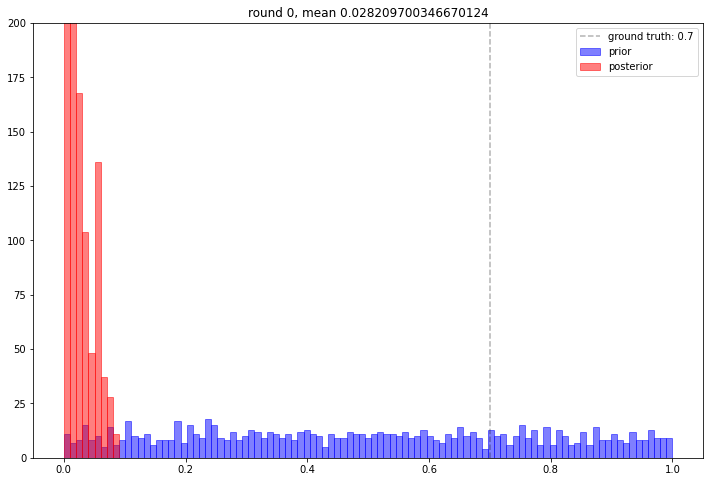

round 0 posterior mean 0.028209700346670124
round 25 posterior mean 0.028775662686065327
round 50 posterior mean 0.03197368650557145
round 75 posterior mean 0.03173838444554002


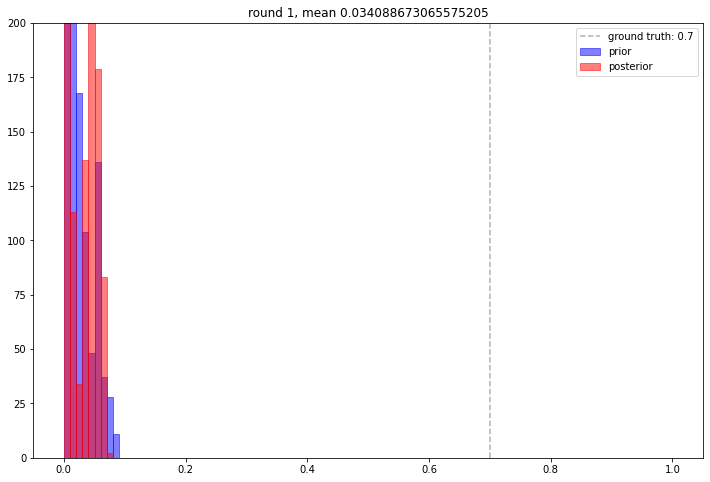

round 0 posterior mean 0.034088673065575205
round 25 posterior mean 0.031429075305585925
round 50 posterior mean 0.028172393272184473
round 75 posterior mean 0.031293467789877835


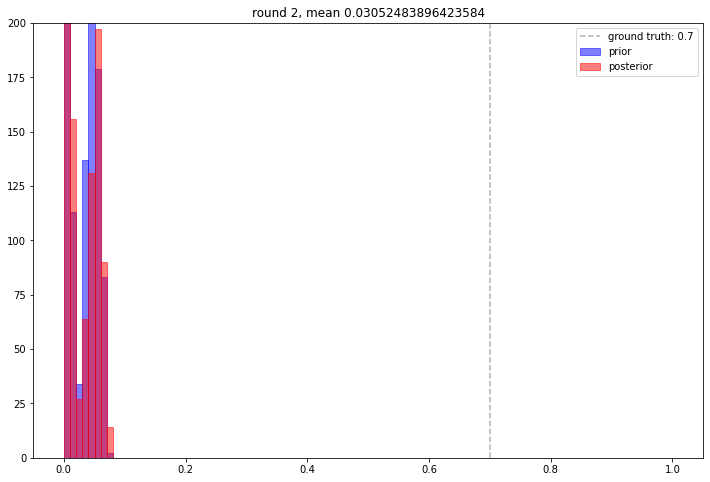

In [51]:
# Initialize uniform prior of right_bound

N = 1000
T = 100

gamma = np.ones((N,)) * 0.98
delta = np.ones((N,)) * 0.15
theta = np.ones((N,)) * 0.7
rho = np.random.uniform(0, 1.0, size=(N,))
sigma = np.ones((N,)) * 0.15

prior_context_particles = np.abs(np.vstack((gamma, delta, theta, rho, sigma)).T)
imp_context_distribution = ParticleDistribution(dim=5, particles=prior_context_particles, n_particles=N)

ray.shutdown()
ray.init()

imp_solver = ppo.PPOTrainer(env=cMDPWhited, config={
                                                "env_config":  {"context_distribution": imp_context_distribution,
                                                                "psi_fn": lambda i, k: 0.01*i**2/(2*k)},
                                                "framework": "torch",  # config to pass to env class
                                            })

for update_round in range(3):
    # burn in training
    if update_round == 0:
        for i in range(15):
            imp_solver.train()

    context_history_imp, imp_context_distribution = filter_context(imp_solver,
                                       imp_context_distribution,
                                       gt_obs_arr,
                                       T,
                                       N
                                       )

    fig, ax = plt.subplots()
    HIST_BINS = np.linspace(0, 1, 100)
    ax.hist(context_history_imp[0][:, 3], HIST_BINS, lw=1,
            ec="blue", fc="blue", alpha=0.5)
    ax.hist(context_history_imp[-1][:, 3], HIST_BINS, lw=1,
            ec="red", fc="red", alpha=0.5)
    plt.axvline(x=0.7, alpha=0.3, color='black', linestyle='--')
    plt.legend(['ground truth: 0.7', 'prior', 'posterior'])
    ax.set_ylim(top=N / 5)
    fig.set_size_inches(12, 8)
    plt.title(f'round {update_round}, mean {context_history_imp[-1][:, 3].mean()}')
    plt.show()

    imp_solver.workers.foreach_worker(
                lambda ev: ev.foreach_env(
                    lambda env: env.set_task(imp_context_distribution)))
    for _ in range(4):
        imp_solver.train()
